# Real-Time Object Detection using YOLOv2 and trained on COCO dataset

In [ ]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from pycocotools.coco import COCO
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import os
import skimage.io as io
import random
import numpy as np
import pandas as pd
import cv2 as cv

### Install Libraries

In [ ]:
!pip install mxnet

     |████████████████████████████████| 55.0MB 77kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install gluoncv

     |████████████████████████████████| 1.0MB 4.9MB/s 
     |████████████████████████████████| 317kB 17.5MB/s 
     |████████████████████████████████| 245kB 17.3MB/s 
     |████████████████████████████████| 11.8MB 18.2MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 972kB 42.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133kB 45.9MB/s 
     |████████████████████████████████| 215kB 36.1MB/s 
     |████████████████████████████████| 675kB 42.8MB/s 
     |████████████████████████████████| 7.1MB 33.9MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 962kB 39.7MB/s 
     |████████████████████████████████| 2.6MB 35.8MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for ConfigSpace: filena

In [ ]:
# Install cython
!pip install cython

### Load Data

In [ ]:
!ls

sample_data


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2020-12-12 10:30:59--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.130.219
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.130.219|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  63.4MB/s    in 5m 14s  

2020-12-12 10:36:13 (58.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
%%capture
!unzip train2017.zip

In [ ]:
!rm train2017.zip

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2020-12-12 10:42:24--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.48.84
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.48.84|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  62.5MB/s    in 13s     

2020-12-12 10:42:37 (61.9 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
%%capture
!unzip val2017.zip

In [ ]:
!rm val2017.zip

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-12-12 10:42:43--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.144.107
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.144.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  90.8MB/s    in 2.7s    

2020-12-12 10:42:46 (90.8 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
%%capture
!unzip annotations_trainval2017.zip

In [ ]:
!rm annotations_trainval2017.zip

In [ ]:
!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip

--2020-12-12 10:42:55--  http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.16.164
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.16.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148688564 (1.1G) [application/zip]
Saving to: ‘stuff_annotations_trainval2017.zip’

stuff_annotations_t 100%[===================>]   1.07G  45.0MB/s    in 16s     

2020-12-12 10:43:11 (68.0 MB/s) - ‘stuff_annotations_trainval2017.zip’ saved [1148688564/1148688564]



In [ ]:
%%capture
!unzip stuff_annotations_trainval2017.zip

In [ ]:
!rm stuff_annotations_trainval2017.zip

In [ ]:
# Install pycocotools from this GitHub rep
!pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI

In [20]:
!ls

annotations  sample_data  train2017  val2017


In [21]:
# Show the class categories 
annFile='/content/annotations/instances_train2017.json'

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=17.07s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, '

In [22]:
import json
train_label_file = open('/content/annotations/instances_train2017.json')
val_label_file = open('/content/annotations/instances_val2017.json')

train_labels = json.load(train_label_file)
val_labels = json.load(val_label_file)


In [23]:
train_labels

{'annotations': [{'area': 2765.1486500000005,
   'bbox': [199.84, 200.46, 77.71, 70.88],
   'category_id': 58,
   'id': 156,
   'image_id': 558840,
   'iscrowd': 0,
   'segmentation': [[239.97,
     260.24,
     222.04,
     270.49,
     199.84,
     253.41,
     213.5,
     227.79,
     259.62,
     200.46,
     274.13,
     202.17,
     277.55,
     210.71,
     249.37,
     253.41,
     237.41,
     264.51,
     242.54,
     261.95,
     228.87,
     271.34]]},
  {'area': 1545.4213000000007,
   'bbox': [234.22, 317.11, 149.39, 38.55],
   'category_id': 58,
   'id': 509,
   'image_id': 200365,
   'iscrowd': 0,
   'segmentation': [[247.71,
     354.7,
     253.49,
     346.99,
     276.63,
     337.35,
     312.29,
     333.49,
     364.34,
     331.57,
     354.7,
     327.71,
     369.16,
     325.78,
     376.87,
     333.49,
     383.61,
     330.6,
     379.76,
     321.93,
     365.3,
     320.0,
     356.63,
     317.11,
     266.02,
     331.57,
     260.24,
     334.46,
     

In [24]:
id_file = open('/content/annotations/deprecated-challenge2017/train-ids.txt')


In [25]:
from gluoncv import data, utils
from matplotlib import pyplot as plt

train_dataset = data.COCODetection(root = '/content', splits=['instances_train2017'])
val_dataset = data.COCODetection(root = '/content',splits=['instances_val2017'])
print('Number of training images:', len(train_dataset))
print('Number of validation images:', len(val_dataset))


loading annotations into memory...
Done (t=19.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
Number of training images: 117266
Number of validation images: 4952


Image size (height, width, RGB): (428, 640, 3)
Num of objects: 2
Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):
 [[204.86  31.02 458.74 354.14]
 [237.56 155.81 402.96 350.06]]
Class IDs (num_boxes, ):
 [[58.]
 [75.]]


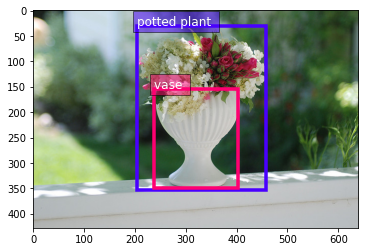

In [26]:
train_image, train_label = train_dataset[2]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
print('Image size (height, width, RGB):', train_image.shape)
print('Num of objects:', bounding_boxes.shape[0])
print('Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):\n',
      bounding_boxes)
print('Class IDs (num_boxes, ):\n', class_ids)

utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores=None,
                    labels=class_ids, class_names=train_dataset.classes)
plt.show()

### Preprocessing Data

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size_train=100
batch_size_validate = 100

In [29]:
## Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
## Train Generator
# dir = '/content/train2017'
train_generator = train_datagen.flow_from_directory(
    '/content/train2017', 
    target_size=IMAGE_SIZE,
    class_mode='input',
    batch_size=batch_size_train,
    shuffle=False
)

Found 0 images belonging to 0 classes.


In [31]:
## Validation Generator
validate_generator = validation_datagen.flow_from_directory(
    '/content/val2017', 
    target_size=IMAGE_SIZE,
    class_mode='input',
    batch_size=batch_size_validate
)

Found 0 images belonging to 0 classes.


In [32]:
def imShowCv(image):
  height, width = image.shape[:2]
  resized_image = cv.resize(image,(3*width, 3*height), interpolation = cv.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv.cvtColor(resized_image, cv.COLOR_BGR2RGB))

In [33]:
from PIL import Image
from numpy import asarray
# load the image
image = Image.open('/content/train2017/000000558840.jpg')
# convert image to numpy array
train_image = asarray(image)
# train_image = cv.imread('/content/train2017/000000000001.jpg')
train_image

array([[[23, 23, 25],
        [21, 21, 23],
        [21, 19, 24],
        ...,
        [10,  9,  7],
        [ 9,  8,  6],
        [13, 12, 10]],

       [[22, 23, 27],
        [21, 22, 26],
        [21, 20, 25],
        ...,
        [12, 10, 11],
        [11, 10,  8],
        [12, 11,  9]],

       [[17, 21, 24],
        [17, 21, 24],
        [19, 20, 24],
        ...,
        [11,  9, 10],
        [11, 11, 11],
        [10, 10, 10]],

       ...,

       [[27, 28, 20],
        [29, 26, 21],
        [25, 27, 16],
        ...,
        [ 7,  7,  7],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[26, 27, 21],
        [29, 26, 21],
        [26, 28, 17],
        ...,
        [ 7,  7,  7],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[24, 25, 19],
        [28, 25, 20],
        [27, 29, 18],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 5,  5,  5]]], dtype=uint8)

(2, 5)
[[385.53  60.03 599.5  356.19]
 [ 53.01 356.49 184.04 410.68]]
[[23.]
 [23.]]
<class 'numpy.ndarray'>


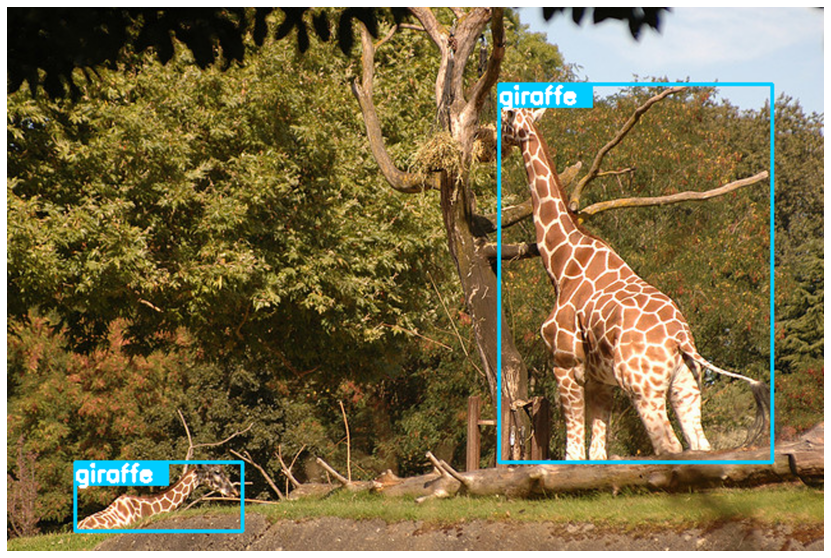

In [34]:
train_image, train_label = train_dataset[1]
# train_image = cv.imread('/content/train2017/000000000001.jpg', 0)
# train_label = train_labels['annotations'][0]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
# img_id = train_label['image_id']
print(train_label.shape)



print(bounding_boxes)
print(class_ids)

train_image = train_image.asnumpy()
print(type(train_image))
train_image = cv.cvtColor(train_image, cv.COLOR_BGR2RGB)


for i in range(len(class_ids)):
  
  class_id = str(int(class_ids[i][0]))
  bbox = bounding_boxes[i]
  
  x1 = int(bbox[0])
  y1 = int(bbox[1])
  x2 = int(bbox[2])
  y2 = int(bbox[3])
  
  
  cv.rectangle(train_image, (x1, y1), (x2, y2), (255, 204, 0), 2)
  ((label_width, label_height), _) = cv.getTextSize(
        train_dataset.classes[int(class_ids[i][0])],
        fontFace=cv.FONT_HERSHEY_PLAIN,
        fontScale=1.2,
        thickness=2
    )
  cv.rectangle(
      train_image,
      (x1, y1),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.50)),
      color=(255, 204, 0),
      thickness=cv.FILLED,
    )
  cv.putText(train_image,train_dataset.classes[int(class_ids[i][0])], (x1, int(y1+ label_height + label_height * 0.25)), cv.FONT_HERSHEY_SIMPLEX, 0.6,(255, 255, 255), 2)
  


imShowCv(train_image)

In [35]:
def create_dataset(datasets):
  images = []
  labels = []
  i = 0;
  for dataset in datasets:
    images[i], labels[i] = dataset[i]
    images
    i+= 1
  return images,labels

In [36]:
train_images, train_labels = create_dataset(train_dataset)

ValueError: ignored

In [ ]:
train_label

array([[385.53,  60.03, 599.5 , 356.19,  23.  ],
       [ 53.01, 356.49, 184.04, 410.68,  23.  ]])

### Convert to YOLO format
- One txt with labels file per image
- One row per object
- Each row contains: class_index bbox_x_center bbox_y_center bbox_width bbox_height
- Box coordinates must be normalized between 0 and 1

### Training Model

- Building YOLOv2 model from the paper

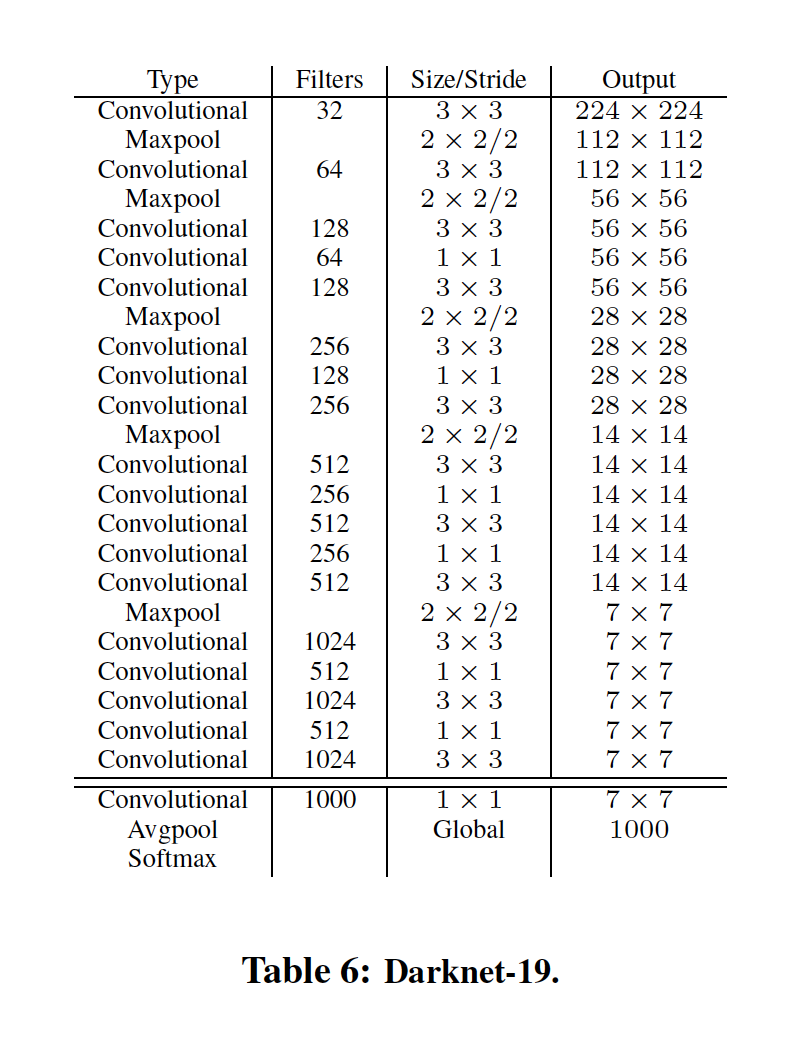

In [ ]:
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

### model
Reference<br>
[ https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/ ]<br>
[ https://towardsdatascience.com/yolo-v3-object-detection-with-keras-461d2cfccef6 ]

In [ ]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3

import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0


In [ ]:
# define the model
model = make_yolov3_model()
# load the model weights
# weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
# weight_reader.load_weights(model)
# save the model to file
# model.save('model.h5')

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

### Evaluation

### Model Tuning